In [13]:
import numpy as np
from pyglet import gl
import pyglet

import imgui
from imgui.integrations.pyglet import PygletRenderer
from jupyter_rfb import RemoteFrameBuffer
import time
import math
import ctypes

In [14]:
class ImGuiWidget(RemoteFrameBuffer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # Store base scale for resolution correction
        self.base_scale = 1.0
        self.override_pixel_ratio = None
        
        # Base window size (logical pixels)
        self.base_width = 800
        self.base_height = 600
        
        # Create a hidden Pyglet window with proper config
        config = gl.Config(
            double_buffer=False,
            depth_size=24,
            sample_buffers=1,
            samples=4,
            # major_version=3,
            # minor_version=3
            
        )
        
        # Create window with base size
        self.window = pyglet.window.Window(
            width=self.base_width,
            height=self.base_height,
            visible=False,
            config=config,
        )
        

        # Initialize ImGui
        imgui.create_context()
        self.io = imgui.get_io()
        
        # Configure initial ImGui state
        # imgui.CONFIG
        # self.io.config_flags |= imgui.CONFIG_DOCKING_ENABLE
        # self.renderer = MyRenderer(self.window)
        self.renderer = PygletRenderer(self.window)
        
        # Set initial display size and scale
        self.io.display_size = self.window.get_size()
        self.io.display_fb_scale = (1, 1)
        
        # Create framebuffer for offscreen rendering
        self._setup_framebuffer()
        
        self._last_frame_time = time.time()


    def _setup_projection(self):
        io = imgui.get_io()
        width, height = io.display_size
    
        # Create an orthographic projection matrix
        projection = np.array([
            [2.0 / width, 0.0,          0.0, 0.0],
            [0.0,         -2.0 / height,0.0, 0.0],
            [0.0,         0.0,          -1.0, 0.0],
            [-1.0,        1.0,          0.0, 1.0]
        ], dtype=np.float32)
    
        # Use the shader program
        gl.glUseProgram(self.shader_program)
    
        # Upload the projection matrix to the shader
        proj_loc = gl.glGetUniformLocation(self.shader_program, b"projection_matrix")
        gl.glUniformMatrix4fv(proj_loc, 1, gl.GL_FALSE, projection.ctypes.data_as(ctypes.POINTER(ctypes.c_float)))
    
    def _setup_framebuffer(self):
        self.window.switch_to()
        
        # Calculate physical dimensions
        width = int(self.io.display_size[0] * self.io.display_fb_scale[0])
        height = int(self.io.display_size[1] * self.io.display_fb_scale[1])
        
        # Create framebuffer
        self.fbo = gl.GLuint()
        gl.glGenFramebuffers(1, self.fbo)
        gl.glBindFramebuffer(gl.GL_FRAMEBUFFER, self.fbo)
        
        # Create texture for color attachment with physical dimensions
        self.color_tex = gl.GLuint()
        gl.glGenTextures(1, self.color_tex)
        gl.glBindTexture(gl.GL_TEXTURE_2D, self.color_tex)
        gl.glTexImage2D(
            gl.GL_TEXTURE_2D, 0, gl.GL_RGB,
            width, height,
            0, gl.GL_RGB, gl.GL_UNSIGNED_BYTE, None
        )
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MIN_FILTER, gl.GL_LINEAR)
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MAG_FILTER, gl.GL_LINEAR)
        
        # Attach texture to framebuffer
        gl.glFramebufferTexture2D(
            gl.GL_FRAMEBUFFER, gl.GL_COLOR_ATTACHMENT0,
            gl.GL_TEXTURE_2D, self.color_tex, 0
        )
        
        # Check framebuffer is complete
        status = gl.glCheckFramebufferStatus(gl.GL_FRAMEBUFFER)
        if status != gl.GL_FRAMEBUFFER_COMPLETE:
            raise RuntimeError(f"Framebuffer is not complete: {status}")
        
        # Setup viewport with physical dimensions
        gl.glViewport(0, 0, width, height)

    def get_frame(self):
        self.window.switch_to()
        gl.glBindFramebuffer(gl.GL_FRAMEBUFFER, self.fbo)
        
        # Calculate delta time
        current_time = time.time()
        self.io.delta_time = max(current_time - self._last_frame_time, 1/1000.0)
        self._last_frame_time = current_time
        
        # Clear the framebuffer
        gl.glClearColor(0.0, 0.0, 0.0, 1.0)
        gl.glClear(gl.GL_COLOR_BUFFER_BIT)
        
        # Start ImGui frame
        imgui.new_frame()
        
        # User-defined GUI code
        self._draw_gui()
        
        # Render ImGui
        imgui.render()
        self.renderer.render(imgui.get_draw_data())
        
        # Read pixels
        gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)
        gl.glPixelStorei(gl.GL_UNPACK_ALIGNMENT, 1)
        
        # Get the physical framebuffer dimensions
        width = int(self.io.display_size[0] * self.io.display_fb_scale[0])
        height = int(self.io.display_size[1] * self.io.display_fb_scale[1])
        
        # Create buffer with correct size for physical dimensions
        buffer_size = width * height * 3
        pixel_buffer = (gl.GLubyte * buffer_size)(0)
        
        # Read pixels at physical resolution
        gl.glReadPixels(
            0, 0, width, height,
            gl.GL_RGB, gl.GL_UNSIGNED_BYTE,
            pixel_buffer
        )
        
        # Convert to numpy array and fix orientation
        frame = np.frombuffer(pixel_buffer, dtype=np.uint8)
        frame = frame.reshape(height, width, 3)
        frame = np.flip(frame, axis=0)
        
        return frame

    def handle_event(self, event):
        event_type = event.get('event_type')
        
        if event_type == 'resize':
            self._handle_resize(event)
        elif event_type == 'pointer_move':
            self._handle_mouse_move(event)
        elif event_type == 'pointer_down':
            self._handle_mouse_button(event, True)
        elif event_type == 'pointer_up':
            self._handle_mouse_button(event, False)
        elif event_type == 'key':
            self._handle_keyboard(event)

    def _handle_resize(self, event):
        logical_width = event['width']
        logical_height = event['height']
        pixel_ratio = self.override_pixel_ratio or event.get('pixel_ratio', 1)
    
        print(f"Resize Event - logical_size: ({logical_width}, {logical_height}), pixel_ratio: {pixel_ratio}")
    
        self.io.display_size = (logical_width, logical_height)
        self.io.display_fb_scale = (pixel_ratio, pixel_ratio)
    
        self.window.set_size(int(logical_width), int(logical_height))
    
        # Recreate framebuffer
        gl.glDeleteFramebuffers(1, self.fbo)
        gl.glDeleteTextures(1, self.color_tex)
        self._setup_framebuffer()
    
        # Update the projection matrix after resizing
        # self.renderer._setup_projection()
        self.renderer.on_resize(int(logical_width), int(logical_height))
    
        self.request_draw()
    def _handle_mouse_move(self, event):
        x = event['x']
        y = event['y']
        self.io.mouse_pos = (x, y)
        self.request_draw()
    
    def _handle_mouse_button(self, event, pressed):
        # Determine the source of coordinates
        if 'touches' in event and event['touches']:
            # Use the first touch's 'x' and 'y' for mouse position
            touch = next(iter(event['touches'].values()))
            x = touch['x']
            y = touch['y']
        else:
            # Fallback to event['x'] and 'y'
            x = event['x']
            y = event['y']
    
        # Validate coordinates to prevent negative values
        if x >= 0 and y >= 0:
            self.io.mouse_pos = (x, y)
        else:
            # Optionally, ignore updating mouse_pos or set to last known valid position
            pass  # Here, we choose to ignore invalid positions
    
        # Handle mouse_down flags based on 'buttons'
        if 'buttons' in event:
            # Reset all mouse_down flags
            for i in range(len(self.io.mouse_down)):
                self.io.mouse_down[i] = False
    
            # Set mouse_down flags based on currently pressed buttons
            for btn in event['buttons']:
                # ImGui uses 0-based indexing for mouse buttons
                if btn - 1 < len(self.io.mouse_down) and btn > 0:
                    self.io.mouse_down[btn - 1] = True
    
        # Debugging: Print the event for verification
        print(f'{event=}')
    
        self.request_draw()

    def _handle_keyboard(self, event):
        key = event['key']
        pressed = event['pressed']
        
        key_index = self._map_key(key)
        if key_index is not None:
            self.io.keys_down[key_index] = pressed
            
        # Handle modifiers
        modifiers = event.get('modifiers', ())
        self.io.key_shift = 'Shift' in modifiers
        self.io.key_ctrl = 'Control' in modifiers
        self.io.key_alt = 'Alt' in modifiers
        self.io.key_super = 'Meta' in modifiers
        
        self.request_draw()

    def _map_key(self, key_name):
        key_map = {
            'ArrowLeft': imgui.KEY_LEFT_ARROW,
            'ArrowRight': imgui.KEY_RIGHT_ARROW,
            'ArrowUp': imgui.KEY_UP_ARROW,
            'ArrowDown': imgui.KEY_DOWN_ARROW,
            'Enter': imgui.KEY_ENTER,
            'Escape': imgui.KEY_ESCAPE,
            'Tab': imgui.KEY_TAB,
            'Backspace': imgui.KEY_BACKSPACE,
            'Delete': imgui.KEY_DELETE,
            'Space': imgui.KEY_SPACE,
            'Home': imgui.KEY_HOME,
            'End': imgui.KEY_END,
            'PageUp': imgui.KEY_PAGE_UP,
            'PageDown': imgui.KEY_PAGE_DOWN,
        }
        return key_map.get(key_name)

    def _draw_gui(self):
        imgui.show_demo_window()

    def set_scale(self, scale):
        self.base_scale = scale
        self._imgui_scale_all_sizes(imgui.get_style(), scale, scale)
        self.io.font_global_scale = scale
    
        # Rebuild the font atlas with the new scale
        self.io.fonts.clear()  # Clear existing fonts
        self.io.fonts.add_font_default()  # Add default font; customize as needed
        # self.io.fonts.build()
    
        # Refresh the font texture in the renderer
        self.renderer.refresh_font_texture()
    
        self.request_draw()

    def _imgui_scale_all_sizes (self, style, hscale: float, vscale: float) -> None:
        """pyimgui is missing ImGuiStyle::ScaleAllSizes(); this is a reimplementation of it."""
        
        scale = max(hscale, vscale)
        
        def scale_it (attrname: str) -> None:
            value = getattr(style, attrname)
            if isinstance(value, imgui.Vec2):
                value = imgui.Vec2(math.trunc(value.x * hscale), math.trunc(value.y * vscale))
                setattr(style, attrname, value)
            else:
                setattr(style, attrname, math.trunc(value * scale))
        
        scale_it("window_padding")
        scale_it("window_rounding")
        scale_it("window_min_size")
        scale_it("child_rounding")
        scale_it("popup_rounding")
        scale_it("frame_padding")
        scale_it("frame_rounding")
        scale_it("item_spacing")
        scale_it("item_inner_spacing")
        scale_it("cell_padding")
        scale_it("touch_extra_padding")
        scale_it("indent_spacing")
        scale_it("columns_min_spacing")
        scale_it("scrollbar_size")
        scale_it("scrollbar_rounding")
        scale_it("grab_min_size")
        scale_it("grab_rounding")
        scale_it("log_slider_deadzone")
        scale_it("tab_rounding")
        scale_it("tab_min_width_for_close_button")
        #scale_it("separator_text_padding")  # not present in current pyimgui
        scale_it("display_window_padding")
        scale_it("display_safe_area_padding")
        scale_it("mouse_cursor_scale")
        
    def force_pixel_ratio(self, ratio):
        self.override_pixel_ratio = ratio
        physical_width, physical_height = self.window.get_size()
        self._handle_resize({
            'width': physical_width,
            'height': physical_height,
            'pixel_ratio': ratio
        })

    def close(self):
        # Clean up OpenGL resources
        gl.glDeleteFramebuffers(1, self.fbo)
        gl.glDeleteTextures(1, self.color_tex)
        
        # Clean up ImGui
        self.renderer.shutdown()
        imgui.destroy_context()
        
        # Close window
        self.window.close()
        super().close()

In [15]:
gui = ImGuiWidget()

RFBOutputContext()

Resize Event - logical_size: (500.0, 300.0), pixel_ratio: 1


ImGuiWidget()
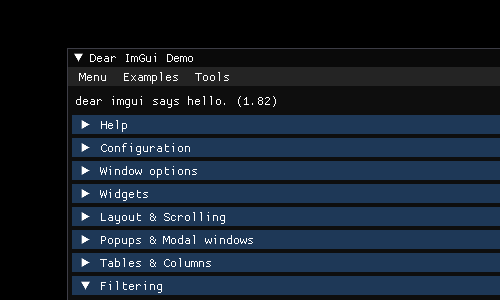

In [16]:
gui